# <span style='color:slateblue'>Trabalho #1 de Aprendizado de Máquina - UFMG - 2018/1</span>

## <span style='color:slateblue'>Eduardo Santiago Ramos</span>
## <span style='color:slateblue'>Prof. Adriano Veloso</span>

## Enunciado

### Redes Neuronais + Backpropagation

Neste trabalho você irá implementar uma rede neuronal com **três camadas**:

1. Camada de entrada: cada unidade representa uma dimensão do dado de entrada.

2. Camada oculta: cada unidade representa uma transformação a partir das unidades de entrada.

3. Camada de saída: cada unidade representa a chance da saída correspondente ser a correta.

Você irá utilizar a função **Sigmóide** para obter não-linearidade. Além disso, a **função de perda** a ser minimizada é a seguinte:
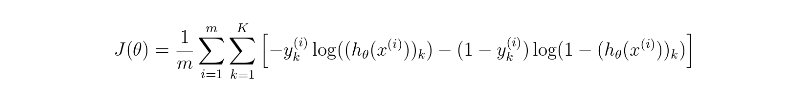

onde *m* é a quantidade de entradas no treino, *K* é o número de saídas possíveis, *$y_k^{(i)}$* representa a saída correta de cada classe k em cada entrada *$(i)$*, e similarmente *$(h_\theta(x^{(i)})_k$* representa a saída dada pela rede neuronal.

O dado a ser utilizado está anexado. Trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., **MNIST dataset**). Dessa forma, *m=5000 e K=10*. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto.

A rede neuronal a ser implementada deverá ter **784 unidades de entrada e 10 unidades de saída**. Em seus experimentos, você deverá **variar o número de unidades na camada oculta (25, 50, 100)**.

Além disso, você deverá comparar os seguintes algoritmos de cálculo de gradiente:

1. **Gradient Descent**: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. **Stochastic Gradient Descent**: o gradiente é calculado após cada entrada.

3. **Mini-Batch**: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

Por fim, você também deverá **variar a taxa de aprendizado: 0.5, 1, 10**.

O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar **discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos** de cálculo de gradiente. Você deverá apresentar **gráficos mostrando a convergência do erro empírico para cada situação** (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá **deixar claras todas as hipóteses** que julgar serem pertinentes.

# 1. Imports

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

# 2. Leitura dos dados e separação dos conjuntos de treinamento e teste

### <span style='color:darkmagenta'>Premissa</span>:
Como o objetivo do trabalho é comparar configurações específicas da rede, e não realizar *model selection*, não foi separado um conjunto de validação. Especificamente, 80% das amostras foram utilizadas para treinamento e 20% para teste.

In [2]:
# Le dados. Amostra i fica em X[i,:] e y[i]
y_mnist = np.zeros((0,))
X_mnist = np.zeros((0,784))
with open('data_tp1') as f:
    for line in f:
        line_vec = np.array(line.strip().split(sep=',')).astype(float)
        y_mnist = np.append(y_mnist, line_vec[0].reshape(1,).astype(int))
        X_mnist = np.append(X_mnist, line_vec[1:].reshape((1,784)), axis=0)
f.close()

assert X_mnist.shape[-1] == 784 # garante que esta com as dimensoes corretas

y = 9.0


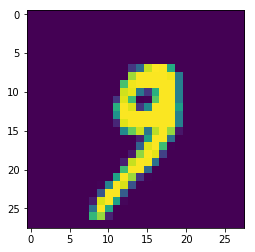

In [3]:
# Valida a leitura dos dados
smpl = 1000
print('y = ' + str(y_mnist[smpl]))
_ = plt.imshow(X=X_mnist[smpl,:].reshape((28,28)))

In [4]:
# Cardinalidades
m = len(y_mnist)
img_dim = 28

# Indices de treinamento e teste
np.random.seed(1) # padroniza
n_train = np.ceil(0.8*m).astype(int)
i_perm = np.random.permutation(m)
i_train, i_test = i_perm[:n_train], i_perm[n_train:]

# Conjuntos de treinamento e teste normalizados (entre 0 e 1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_mnist[i_train, :])
X_test  = scaler.fit_transform(X_mnist[i_test, :])
y_train = y_mnist[i_train]
y_test  = y_mnist[i_test]

# Cria um dicionario
data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

# 3. Define a rede neural

Neste trabalho foi utilizado o `TensorFlow` para realizar o trabalho.

## 3.1 Arquitetura da rede
A rede possui **3 camadas**, como descrito no enunciado: entrada, oculta e saída

## 3.2 Execução com o `TensorFlow` - função `executa_rede()`
Para implementar a rede com o TensorFlow, há duas etapas a serem cumpridas:
1. Criar um **grafo de computação**, o qual irá deixar registradas as operações e dependências necessárias para a execução.
- Criar uma **sessão** e realizar a execução do grafo.

Estas duas etapas estão destacadas na função principal do trabalho - `executa_rede()`.

In [5]:
def executa_rede(data, dim, optimizer, n_epochs, n_batches):
    '''Cria, define e otimiza uma rede neural com o TensorFlow
    
       Entradas:
       data - dicionario com os dados de treinamento e teste (keys: 'X_train', 'X_test', 'y_train', 'y_test')
       dim - dimensoes da rede tamanho_entrada, tamanho_cam_escondida, tamanho_saida)
       n_epochs - numero de epocas da otimizacao
       n_batches - numero de batches a ser utilizado por epoca
    '''
    # ======================================== Parte I. Fase de configuracao ======================================== #
    # Dimensoes da rede
    n_inputs, n_hidden, n_outputs = dim
    
    # Reseta o grafo
    tf.reset_default_graph()

    # Define a entrada
    X = tf.placeholder(dtype=tf.float32, shape=(None,n_inputs), name='Entrada')

    # Define a camada escondida
    # Pesos e vieses
    W1 = tf.get_variable(name='Pesos1', dtype=tf.float32, shape=(n_inputs, n_hidden),
                        initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable(name='Vies1', dtype=tf.float32, shape=(n_hidden), 
                        initializer=tf.zeros_initializer())
    # Logits: Z1 = X*W1^T + b1
    Z1 = tf.add(tf.matmul(X, W1), b1, name='Logits1')
    # Ativacao: A1 = sigmoid(Z1)
    A1 = tf.sigmoid(Z1, name='Ativacao1')

    # Define camada de saida
    # Pesos e vieses
    W2 = tf.get_variable(name='Pesos2', dtype=tf.float32, shape=(n_hidden, n_outputs),
                        initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable(name='Vies2', dtype=tf.float32, shape=(n_outputs), 
                        initializer=tf.zeros_initializer())
    # Logits: Z2 = A1*W2^T + b2
    logits = tf.add(tf.matmul(A1, W2), b2, name='Logits2')

    # Saida esperada:
    labels = tf.placeholder(dtype=tf.int32, shape=(None,), name='Labels')

    # Define a funcao objetivo
    logloss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='Previsao')
    global_loss = tf.reduce_mean(logloss, name='Funcao_objetivo')

    # Define a metrica de qualidade - precisao
    # tf.nn.in_top_k: 'Says whether the targets are in the top K predictions.'
    individual_correctness = tf.nn.in_top_k(predictions=logits, targets=labels, k=1, name='Acerto_individual') 
    accuracy = tf.reduce_mean(tf.cast(individual_correctness, tf.float32))

    # Define a operacao de otimizacao
    optim_step = optimizer.minimize(global_loss)

    # Define um inicializador
    init = tf.global_variables_initializer()

    # Define variaveis para acompanhar
    # a. Funcao objetivo - global_loss
    fobj_summary = tf.summary.scalar('Global_Loss', global_loss) # summary of variable to keep track
    # b. Metrica de qualidade - accuracy
    acc_summary = tf.summary.scalar('Accuracy', accuracy) # in-sample

    # Salva o grafo de execucao
    root_logdir = 'tf_logs'
    now = datetime.now().strftime('%Y%m%d_%H%M%S')
    logdir = '{}/run_{}/'.format(root_logdir, now)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    # ========================================= Parte II. Fase de execucao ========================================= #

    # Desempacota os dados
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
    # Vetores que guardarao o erro logistico e a precisao
    err_train = np.full(shape=n_epochs, fill_value=np.nan)
    acc_train = np.full(shape=n_epochs, fill_value=np.nan)
    acc_test = np.full(shape=n_epochs, fill_value=np.nan)
    
    # Tamanho de cada batch
    batch_size = np.floor(len(y_train) / n_batches).astype(int)
    
    # Inicia a sessao
    with tf.Session() as sess:
        # Inicializa as variaveis
        sess.run(init)

        # Loop de execucao
        for epoch in range(n_epochs):
            for batch in range(n_batches):
                # Seleciona batch atual
                start_id = (batch)*batch_size
                if batch==n_batches-1:
                    final_id = len(y_train) # vai ate o fim
                else:
                    final_id = (batch+1)*batch_size
                
                X_batch = X_train[start_id:final_id, :]
                y_batch = y_train[start_id:final_id]

                # Avalia funcao objetivo e precisao e salva
                global_loss_smr, accuracy_smr = sess.run([fobj_summary,acc_summary], 
                                                         feed_dict={X:X_batch, labels:y_batch})
                file_writer.add_summary(global_loss_smr, epoch)
                file_writer.add_summary(accuracy_smr, epoch)

                # Da um passo de otimizacao
                sess.run(optim_step, feed_dict={X: X_batch, labels: y_batch})

            # Imprime e salva dados
            err_train[epoch], acc_train[epoch] = sess.run([global_loss, accuracy], 
                                                              feed_dict={X:X_batch,labels:y_batch})
            acc_test[epoch] = sess.run(accuracy, feed_dict={X:X_test,labels:y_test})
            if epoch % 5 == 0 or epoch == n_epochs-1:
                print('Epoch: {} \t Logistic Loss: {:.4f} \t Accuracy: {:.2f}%'.format(
                                                    epoch, err_train[epoch], acc_train[epoch]*100))
                
    return err_train, acc_train, acc_test

### 3.2.1 Visualizando o grafo de computação com o `TensorBoard`

O `TensorBoard` oferece uma ótima funcionalidade, que é a de poder visualizar o grafo de computação definido para sua sessão (além de diversas outras coisas). Isto ajuda muito a entender o que está por trás dos panos em relação à operação do `TensorFlow`.

Especificamente para este trabalho, o grafo definido na função acima é:

![title](imgs/Grafo_computacao.png)

Nele, é possível vermos como os nós e as operações se interagem para obter o resultado final e otimizar os parâmetros.

# 4. Função auxiliar para imprimir os resultados

In [6]:
def plota_resultados(loss_vec, accuracy_vec, test_vec):
    fig, ax1 = plt.subplots(figsize=(18, 8))

    x = np.arange(len(loss_vec))
    
    color = 'tab:red'
    ax1.set_xlabel('Epoch', fontsize=18)
    ax1.set_ylabel('Erro logistico', color=color, fontsize=18)
    ax1.plot(x, loss_vec, color=color, linewidth=4, label='Erro de treinamento')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(fontsize=12, loc='center right')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy (%)', color=color, fontsize=18)  # we already handled the x-label with ax1
    ax2.plot(x, accuracy_vec*100, color=color, linewidth=4, label='Precisao de treino')
    ax2.plot(x, test_vec*100, color='tab:brown', linewidth=4, label='Precisao de teste')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(fontsize=12, loc='center')
    
    plt.title('Resultado do treinamento', color='tab:brown', fontsize=24)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# 5. Testes
#### Etapas
- Comparacoes:
    1. Numero de unidades na camada oculta - 25, 50, 100
    - Algoritmo de calculo do gradiente - Batch, mini-batch, stochastic
    - Taxa de aprendizado - 0.5, 1, 10
    - Algoritmo de otimizacao - GD, Momentum, Adam
- Apresentar:
    1. Discussao da variacao camada oculta x algoritmos
    - Graficos com a convergencia do erro empirico
    - Deixar claras as hipoteses

### Teste 1/15: <span style='color:orangered'>Batch / 25 unidades / Tx_aprend = 0.5</span>

In [7]:
# Teste 1: Configuracoes
n_hidden = 25         # numero de unidades na camada escondida
learning_rate = 0.5   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 1         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [8]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 2.3412 	 Accuracy: 16.25%
Epoch: 5 	 Logistic Loss: 2.1029 	 Accuracy: 50.08%
Epoch: 10 	 Logistic Loss: 1.9431 	 Accuracy: 61.77%
Epoch: 15 	 Logistic Loss: 1.7875 	 Accuracy: 67.02%
Epoch: 20 	 Logistic Loss: 1.6405 	 Accuracy: 70.82%
Epoch: 25 	 Logistic Loss: 1.5054 	 Accuracy: 74.00%
Epoch: 30 	 Logistic Loss: 1.3845 	 Accuracy: 75.75%
Epoch: 35 	 Logistic Loss: 1.2783 	 Accuracy: 77.42%
Epoch: 40 	 Logistic Loss: 1.1858 	 Accuracy: 78.95%
Epoch: 45 	 Logistic Loss: 1.1057 	 Accuracy: 79.93%
Epoch: 50 	 Logistic Loss: 1.0362 	 Accuracy: 80.77%
Epoch: 55 	 Logistic Loss: 0.9756 	 Accuracy: 81.77%
Epoch: 60 	 Logistic Loss: 0.9227 	 Accuracy: 82.30%
Epoch: 65 	 Logistic Loss: 0.8761 	 Accuracy: 82.88%
Epoch: 70 	 Logistic Loss: 0.8350 	 Accuracy: 83.32%
Epoch: 75 	 Logistic Loss: 0.7984 	 Accuracy: 84.07%
Epoch: 80 	 Logistic Loss: 0.7658 	 Accuracy: 84.28%
Epoch: 85 	 Logistic Loss: 0.7364 	 Accuracy: 84.80%
Epoch: 90 	 Logistic Loss: 0.7100 	 Accuracy: 85

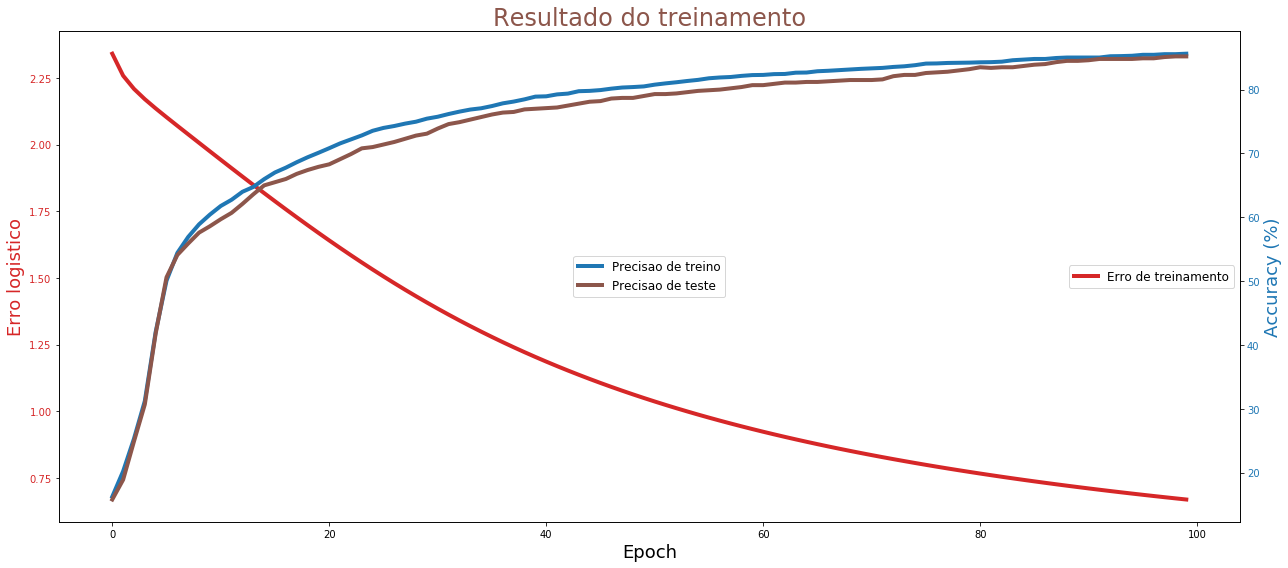

In [9]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 2/15: <span style='color:orangered'>Batch / 25 unidades / Tx_aprend = 1</span>

In [10]:
# Teste 2: Configuracoes
n_hidden = 25         # numero de unidades na camada escondida
learning_rate = 1.0   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 1         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [11]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 2.2465 	 Accuracy: 26.27%
Epoch: 5 	 Logistic Loss: 1.9469 	 Accuracy: 57.98%
Epoch: 10 	 Logistic Loss: 1.6661 	 Accuracy: 63.55%
Epoch: 15 	 Logistic Loss: 1.4233 	 Accuracy: 69.67%
Epoch: 20 	 Logistic Loss: 1.2319 	 Accuracy: 74.35%
Epoch: 25 	 Logistic Loss: 1.0847 	 Accuracy: 77.68%
Epoch: 30 	 Logistic Loss: 0.9705 	 Accuracy: 79.75%
Epoch: 35 	 Logistic Loss: 0.8799 	 Accuracy: 81.58%
Epoch: 40 	 Logistic Loss: 0.8065 	 Accuracy: 82.88%
Epoch: 45 	 Logistic Loss: 0.7459 	 Accuracy: 83.70%
Epoch: 50 	 Logistic Loss: 0.6953 	 Accuracy: 84.43%
Epoch: 55 	 Logistic Loss: 0.6525 	 Accuracy: 85.35%
Epoch: 60 	 Logistic Loss: 0.6160 	 Accuracy: 86.00%
Epoch: 65 	 Logistic Loss: 0.5846 	 Accuracy: 86.22%
Epoch: 70 	 Logistic Loss: 0.5574 	 Accuracy: 86.77%
Epoch: 75 	 Logistic Loss: 0.5335 	 Accuracy: 86.92%
Epoch: 80 	 Logistic Loss: 0.5124 	 Accuracy: 87.25%
Epoch: 85 	 Logistic Loss: 0.4936 	 Accuracy: 87.50%
Epoch: 90 	 Logistic Loss: 0.4768 	 Accuracy: 87

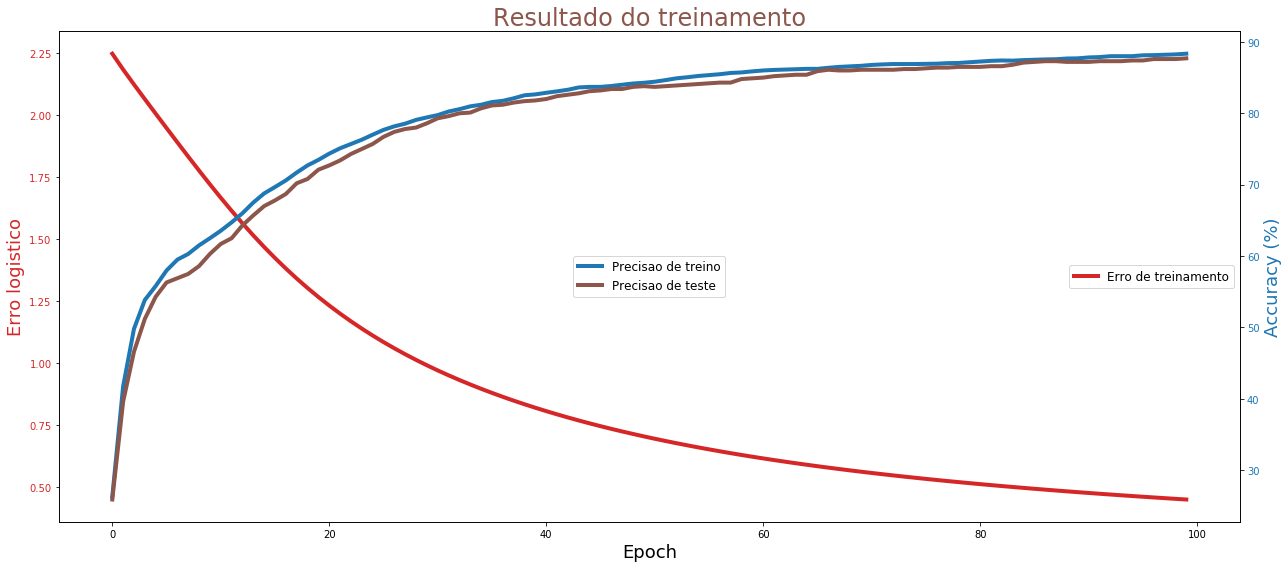

In [12]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 3/15: <span style='color:orangered'>Batch / 25 unidades / Tx_aprend = 10</span>

In [13]:
# Teste 3: Configuracoes
n_hidden = 25         # numero de unidades na camada escondida
learning_rate = 10    # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 1         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [14]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 3.8607 	 Accuracy: 12.50%
Epoch: 5 	 Logistic Loss: 2.1283 	 Accuracy: 19.75%
Epoch: 10 	 Logistic Loss: 1.9593 	 Accuracy: 41.08%
Epoch: 15 	 Logistic Loss: 1.9259 	 Accuracy: 33.75%
Epoch: 20 	 Logistic Loss: 1.5461 	 Accuracy: 43.33%
Epoch: 25 	 Logistic Loss: 1.5954 	 Accuracy: 49.05%
Epoch: 30 	 Logistic Loss: 1.7466 	 Accuracy: 48.15%
Epoch: 35 	 Logistic Loss: 1.3608 	 Accuracy: 53.25%
Epoch: 40 	 Logistic Loss: 0.8608 	 Accuracy: 70.10%
Epoch: 45 	 Logistic Loss: 0.8694 	 Accuracy: 71.22%
Epoch: 50 	 Logistic Loss: 1.2292 	 Accuracy: 61.83%
Epoch: 55 	 Logistic Loss: 0.6651 	 Accuracy: 78.47%
Epoch: 60 	 Logistic Loss: 0.6656 	 Accuracy: 77.07%
Epoch: 65 	 Logistic Loss: 0.7882 	 Accuracy: 77.13%
Epoch: 70 	 Logistic Loss: 0.5087 	 Accuracy: 84.68%
Epoch: 75 	 Logistic Loss: 0.4724 	 Accuracy: 85.68%
Epoch: 80 	 Logistic Loss: 0.5558 	 Accuracy: 83.05%
Epoch: 85 	 Logistic Loss: 0.5670 	 Accuracy: 82.90%
Epoch: 90 	 Logistic Loss: 0.3915 	 Accuracy: 89

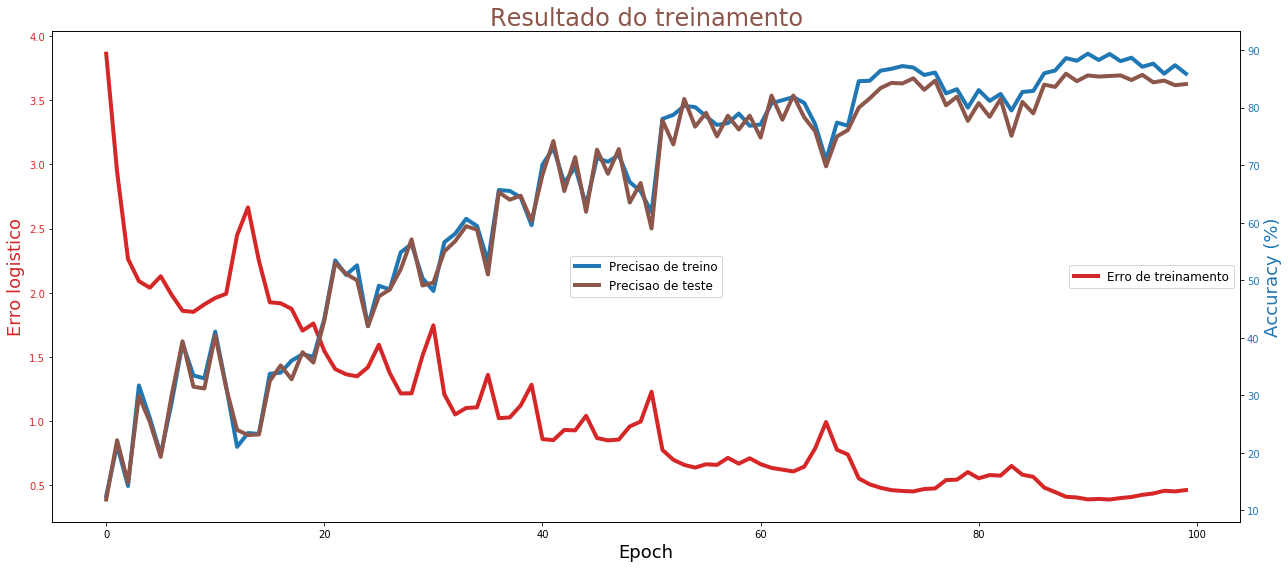

In [15]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

## 5.1 <span style='color:darkmagenta'>Discussão</span>
Ao utilizar *Batch Gradient Descent* com uma função convexa, espera-se que o erro de treinamento (perda logística) caia de forma monotônica. O comportamento do teste acima demonstra que **uma taxa de aprendizado igual a 10 é muito alta, levando o algoritmo a divergir** em alguns momentos. 

**Portanto, a partir de agora, os testes não considerarão mais esta configuração**. As taxas de aprendizado utilizadas serão sempre iguais a **0.5 ou 1**.

### Teste 4/15: <span style='color:orangered'>Batch / 50 unidades / Tx_aprend = 0.5</span>

In [16]:
# Teste 4: Configuracoes
n_hidden = 50         # numero de unidades na camada escondida
learning_rate = 0.5   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 1         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [17]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 2.2804 	 Accuracy: 19.02%
Epoch: 5 	 Logistic Loss: 2.0499 	 Accuracy: 56.45%
Epoch: 10 	 Logistic Loss: 1.8502 	 Accuracy: 68.12%
Epoch: 15 	 Logistic Loss: 1.6607 	 Accuracy: 73.20%
Epoch: 20 	 Logistic Loss: 1.4875 	 Accuracy: 76.13%
Epoch: 25 	 Logistic Loss: 1.3361 	 Accuracy: 78.05%
Epoch: 30 	 Logistic Loss: 1.2079 	 Accuracy: 79.52%
Epoch: 35 	 Logistic Loss: 1.1010 	 Accuracy: 80.75%
Epoch: 40 	 Logistic Loss: 1.0123 	 Accuracy: 81.85%
Epoch: 45 	 Logistic Loss: 0.9387 	 Accuracy: 82.67%
Epoch: 50 	 Logistic Loss: 0.8771 	 Accuracy: 83.07%
Epoch: 55 	 Logistic Loss: 0.8251 	 Accuracy: 83.80%
Epoch: 60 	 Logistic Loss: 0.7808 	 Accuracy: 84.10%
Epoch: 65 	 Logistic Loss: 0.7428 	 Accuracy: 84.45%
Epoch: 70 	 Logistic Loss: 0.7097 	 Accuracy: 84.97%
Epoch: 75 	 Logistic Loss: 0.6808 	 Accuracy: 85.12%
Epoch: 80 	 Logistic Loss: 0.6552 	 Accuracy: 85.43%
Epoch: 85 	 Logistic Loss: 0.6325 	 Accuracy: 85.53%
Epoch: 90 	 Logistic Loss: 0.6121 	 Accuracy: 85

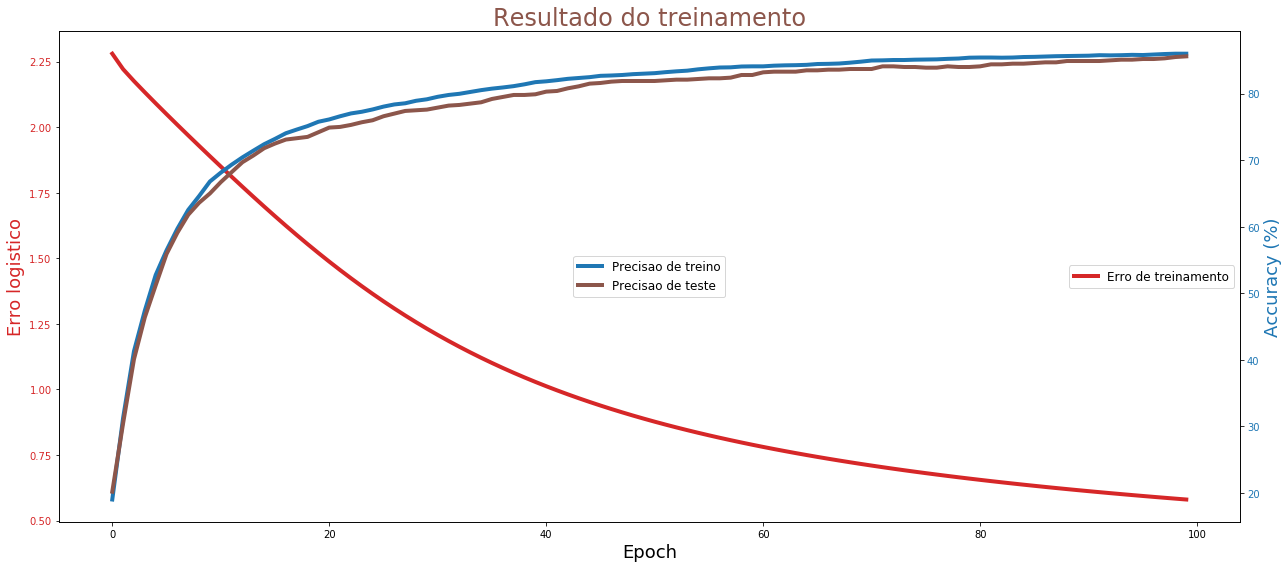

In [18]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 5/15: <span style='color:orangered'>Batch / 50 unidades / Tx_aprend = 1</span>

In [19]:
# Teste 5: Configuracoes
n_hidden = 50         # numero de unidades na camada escondida
learning_rate = 1.0   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 1         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [20]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 2.2624 	 Accuracy: 19.95%
Epoch: 5 	 Logistic Loss: 1.7626 	 Accuracy: 67.45%
Epoch: 10 	 Logistic Loss: 1.4080 	 Accuracy: 75.80%
Epoch: 15 	 Logistic Loss: 1.1471 	 Accuracy: 79.95%
Epoch: 20 	 Logistic Loss: 0.9669 	 Accuracy: 81.60%
Epoch: 25 	 Logistic Loss: 0.8431 	 Accuracy: 82.82%
Epoch: 30 	 Logistic Loss: 0.7554 	 Accuracy: 83.95%
Epoch: 35 	 Logistic Loss: 0.6904 	 Accuracy: 84.45%
Epoch: 40 	 Logistic Loss: 0.6404 	 Accuracy: 85.25%
Epoch: 45 	 Logistic Loss: 0.6004 	 Accuracy: 85.87%
Epoch: 50 	 Logistic Loss: 0.5677 	 Accuracy: 86.60%
Epoch: 55 	 Logistic Loss: 0.5402 	 Accuracy: 87.08%
Epoch: 60 	 Logistic Loss: 0.5167 	 Accuracy: 87.37%
Epoch: 65 	 Logistic Loss: 0.4962 	 Accuracy: 87.55%
Epoch: 70 	 Logistic Loss: 0.4782 	 Accuracy: 87.67%
Epoch: 75 	 Logistic Loss: 0.4621 	 Accuracy: 88.05%
Epoch: 80 	 Logistic Loss: 0.4477 	 Accuracy: 88.20%
Epoch: 85 	 Logistic Loss: 0.4346 	 Accuracy: 88.38%
Epoch: 90 	 Logistic Loss: 0.4226 	 Accuracy: 88

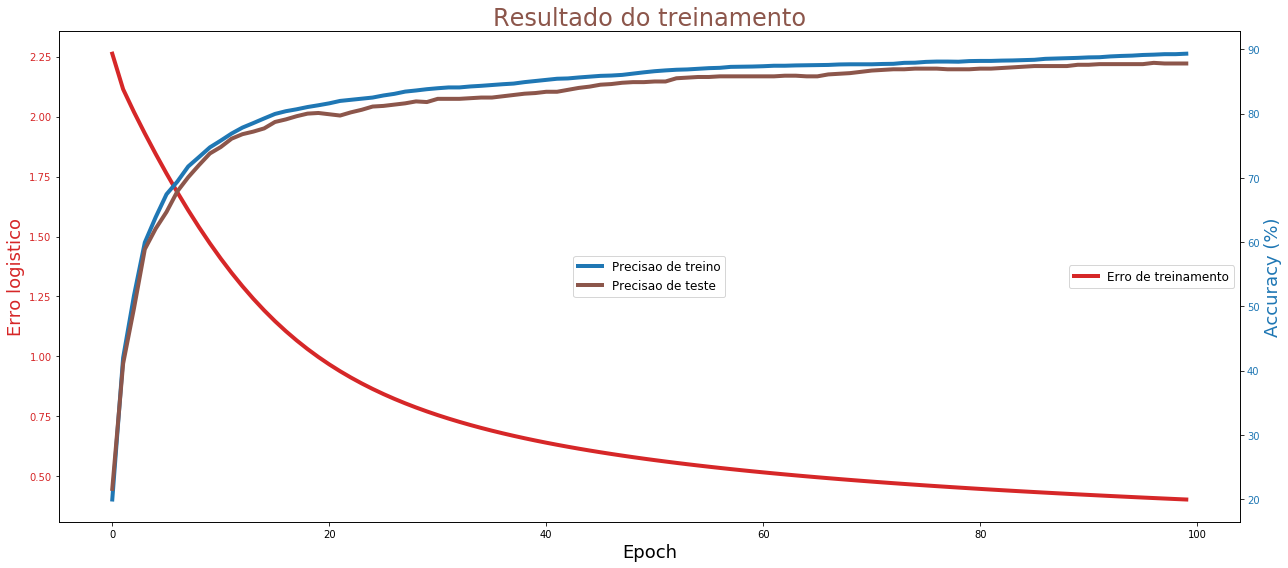

In [21]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 6/15: <span style='color:orangered'>Batch / 100 unidades / Tx_aprend = 0.5</span>

In [22]:
# Teste 6: Configuracoes
n_hidden = 100        # numero de unidades na camada escondida
learning_rate = 0.5   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 1         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [23]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 2.2711 	 Accuracy: 23.38%
Epoch: 5 	 Logistic Loss: 1.9680 	 Accuracy: 62.30%
Epoch: 10 	 Logistic Loss: 1.7192 	 Accuracy: 71.22%
Epoch: 15 	 Logistic Loss: 1.5001 	 Accuracy: 75.10%
Epoch: 20 	 Logistic Loss: 1.3158 	 Accuracy: 77.35%
Epoch: 25 	 Logistic Loss: 1.1666 	 Accuracy: 79.00%
Epoch: 30 	 Logistic Loss: 1.0479 	 Accuracy: 80.52%
Epoch: 35 	 Logistic Loss: 0.9537 	 Accuracy: 81.65%
Epoch: 40 	 Logistic Loss: 0.8781 	 Accuracy: 82.40%
Epoch: 45 	 Logistic Loss: 0.8167 	 Accuracy: 83.15%
Epoch: 50 	 Logistic Loss: 0.7661 	 Accuracy: 83.65%
Epoch: 55 	 Logistic Loss: 0.7237 	 Accuracy: 84.25%
Epoch: 60 	 Logistic Loss: 0.6878 	 Accuracy: 84.75%
Epoch: 65 	 Logistic Loss: 0.6570 	 Accuracy: 85.35%
Epoch: 70 	 Logistic Loss: 0.6302 	 Accuracy: 85.47%
Epoch: 75 	 Logistic Loss: 0.6066 	 Accuracy: 85.80%
Epoch: 80 	 Logistic Loss: 0.5858 	 Accuracy: 85.97%
Epoch: 85 	 Logistic Loss: 0.5672 	 Accuracy: 86.27%
Epoch: 90 	 Logistic Loss: 0.5505 	 Accuracy: 86

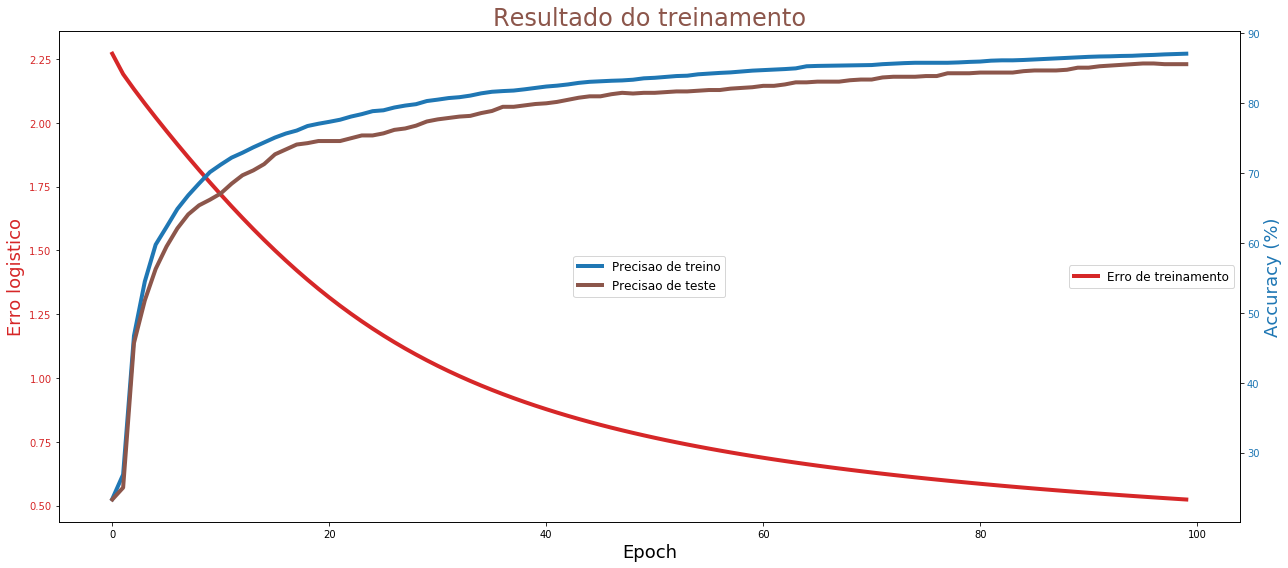

In [24]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 7/15: <span style='color:orangered'>Batch / 100 unidades / Tx_aprend = 1</span>

In [25]:
# Teste 7: Configuracoes
n_hidden = 100        # numero de unidades na camada escondida
learning_rate = 1.0   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 1         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [26]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 3.0689 	 Accuracy: 25.62%
Epoch: 5 	 Logistic Loss: 1.7554 	 Accuracy: 63.45%
Epoch: 10 	 Logistic Loss: 1.3684 	 Accuracy: 71.57%
Epoch: 15 	 Logistic Loss: 1.1959 	 Accuracy: 63.57%
Epoch: 20 	 Logistic Loss: 1.0001 	 Accuracy: 73.50%
Epoch: 25 	 Logistic Loss: 0.8558 	 Accuracy: 74.48%
Epoch: 30 	 Logistic Loss: 0.8013 	 Accuracy: 75.58%
Epoch: 35 	 Logistic Loss: 0.7148 	 Accuracy: 77.32%
Epoch: 40 	 Logistic Loss: 0.6491 	 Accuracy: 80.00%
Epoch: 45 	 Logistic Loss: 0.5936 	 Accuracy: 82.20%
Epoch: 50 	 Logistic Loss: 0.5553 	 Accuracy: 84.62%
Epoch: 55 	 Logistic Loss: 0.5198 	 Accuracy: 85.20%
Epoch: 60 	 Logistic Loss: 0.4933 	 Accuracy: 86.33%
Epoch: 65 	 Logistic Loss: 0.4695 	 Accuracy: 86.92%
Epoch: 70 	 Logistic Loss: 0.4505 	 Accuracy: 87.67%
Epoch: 75 	 Logistic Loss: 0.4342 	 Accuracy: 88.20%
Epoch: 80 	 Logistic Loss: 0.4204 	 Accuracy: 88.60%
Epoch: 85 	 Logistic Loss: 0.4083 	 Accuracy: 88.98%
Epoch: 90 	 Logistic Loss: 0.3975 	 Accuracy: 89

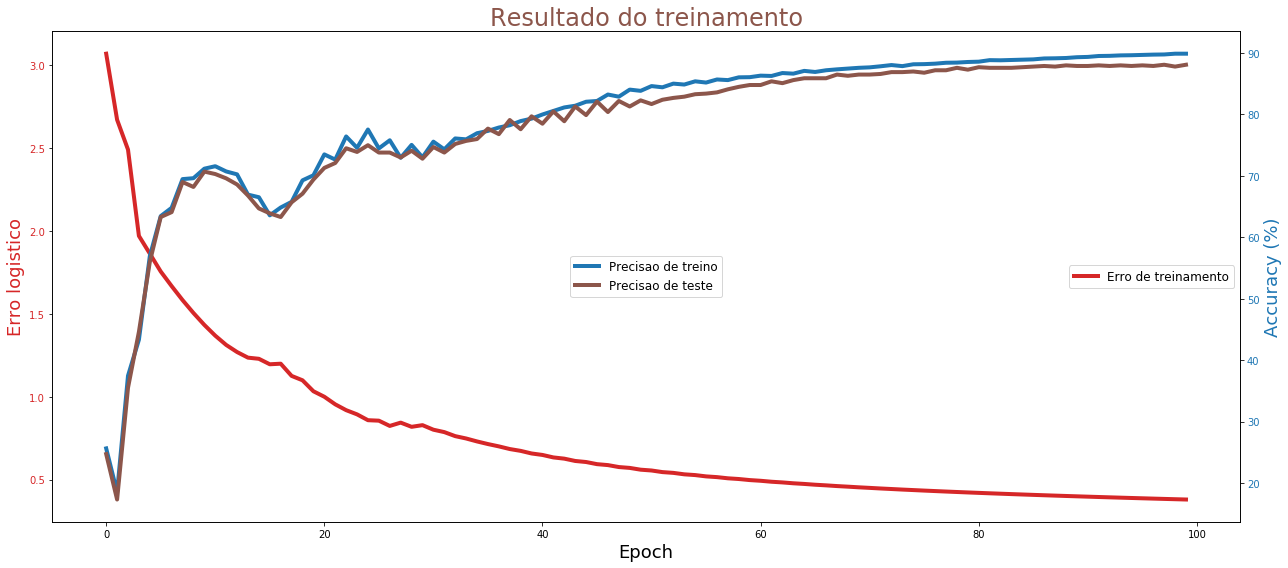

In [27]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

## 5.2 <span style='color:darkmagenta'>Discussão</span>
Para o caso de *Batch Gradient Descent*, **o aumento do número de unidades gerou retornos médios**. De 25 para 50, e de 50 para 100 unidades, o ganho de precisão foi de aproximadamente 1% em cada caso. Além disso, para o caso com 100 unidades e taxa de aprendizado 1, o treinamento apresentou um comportamento mal ajustado em alguns pontos.

Em outras palavras, aparentemente o gargalo da rede, neste ponto, é o número de camadas, e não o número de unidades nesta camada.

### Teste 8/15: <span style='color:orangered'>Mini-Batch / 25 unidades / Tx_aprend = 0.5</span>
No próximo grupo de testes, utilizaremos *Mini-batch Gradient Descent*.

#### <span style='color:darkmagenta'>Premissa</span>
Foram utilizados **50 batches**, de forma que cada um tenha **80 amostras**, o que parece um bom meio termo entre o *Batch* e o *Stochastic*.

In [28]:
# Teste 8: Configuracoes
n_hidden = 25         # numero de unidades na camada escondida
learning_rate = 0.5   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 50        # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [29]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 0.9635 	 Accuracy: 83.75%
Epoch: 5 	 Logistic Loss: 0.2881 	 Accuracy: 95.00%
Epoch: 10 	 Logistic Loss: 0.1856 	 Accuracy: 95.00%
Epoch: 15 	 Logistic Loss: 0.1358 	 Accuracy: 96.25%
Epoch: 20 	 Logistic Loss: 0.1062 	 Accuracy: 97.50%
Epoch: 25 	 Logistic Loss: 0.0857 	 Accuracy: 97.50%
Epoch: 30 	 Logistic Loss: 0.0701 	 Accuracy: 97.50%
Epoch: 35 	 Logistic Loss: 0.0581 	 Accuracy: 98.75%
Epoch: 40 	 Logistic Loss: 0.0488 	 Accuracy: 98.75%
Epoch: 45 	 Logistic Loss: 0.0416 	 Accuracy: 100.00%
Epoch: 50 	 Logistic Loss: 0.0359 	 Accuracy: 100.00%
Epoch: 55 	 Logistic Loss: 0.0314 	 Accuracy: 100.00%
Epoch: 60 	 Logistic Loss: 0.0278 	 Accuracy: 100.00%
Epoch: 65 	 Logistic Loss: 0.0249 	 Accuracy: 100.00%
Epoch: 70 	 Logistic Loss: 0.0225 	 Accuracy: 100.00%
Epoch: 75 	 Logistic Loss: 0.0205 	 Accuracy: 100.00%
Epoch: 80 	 Logistic Loss: 0.0189 	 Accuracy: 100.00%
Epoch: 85 	 Logistic Loss: 0.0175 	 Accuracy: 100.00%
Epoch: 90 	 Logistic Loss: 0.0163 	 Acc

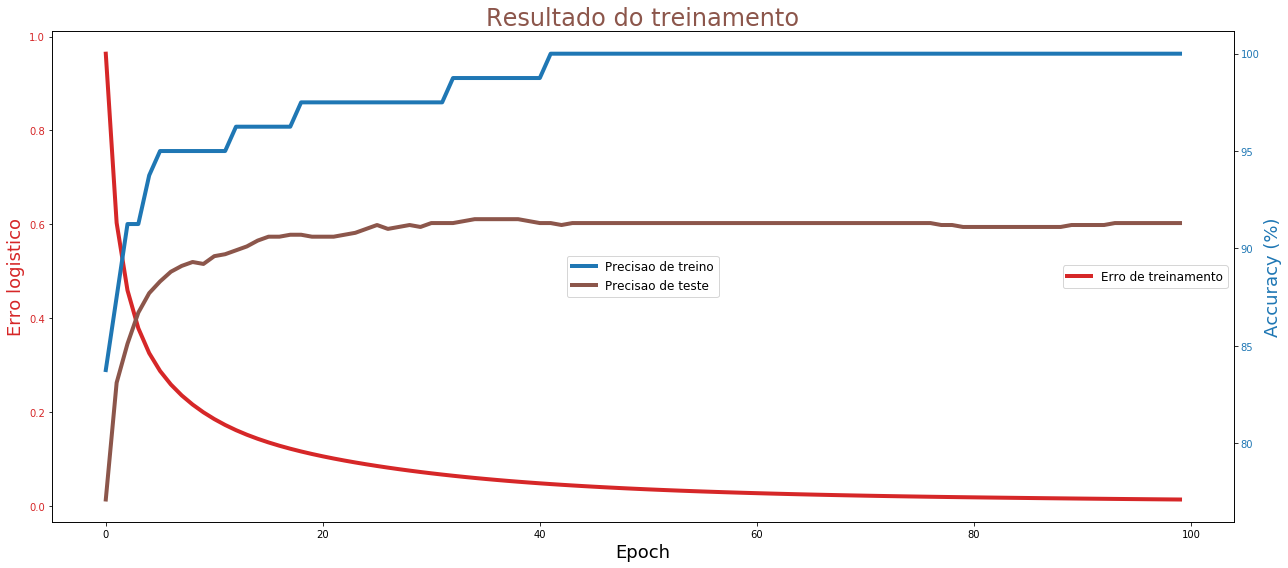

In [30]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 9/15: <span style='color:orangered'>Mini-batch / 25 unidades / Tx_aprend = 1</span>

In [31]:
# Teste 9: Configuracoes
n_hidden = 25         # numero de unidades na camada escondida
learning_rate = 1.0   # taxa de aprendizado
n_epochs = 100        # numero de epocas
n_batches = 50        # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [32]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 0.6275 	 Accuracy: 87.50%
Epoch: 5 	 Logistic Loss: 0.2054 	 Accuracy: 95.00%
Epoch: 10 	 Logistic Loss: 0.1282 	 Accuracy: 96.25%
Epoch: 15 	 Logistic Loss: 0.0841 	 Accuracy: 97.50%
Epoch: 20 	 Logistic Loss: 0.0549 	 Accuracy: 98.75%
Epoch: 25 	 Logistic Loss: 0.0381 	 Accuracy: 100.00%
Epoch: 30 	 Logistic Loss: 0.0287 	 Accuracy: 100.00%
Epoch: 35 	 Logistic Loss: 0.0228 	 Accuracy: 100.00%
Epoch: 40 	 Logistic Loss: 0.0187 	 Accuracy: 100.00%
Epoch: 45 	 Logistic Loss: 0.0158 	 Accuracy: 100.00%
Epoch: 50 	 Logistic Loss: 0.0136 	 Accuracy: 100.00%
Epoch: 55 	 Logistic Loss: 0.0119 	 Accuracy: 100.00%
Epoch: 60 	 Logistic Loss: 0.0106 	 Accuracy: 100.00%
Epoch: 65 	 Logistic Loss: 0.0096 	 Accuracy: 100.00%
Epoch: 70 	 Logistic Loss: 0.0087 	 Accuracy: 100.00%
Epoch: 75 	 Logistic Loss: 0.0080 	 Accuracy: 100.00%
Epoch: 80 	 Logistic Loss: 0.0074 	 Accuracy: 100.00%
Epoch: 85 	 Logistic Loss: 0.0068 	 Accuracy: 100.00%
Epoch: 90 	 Logistic Loss: 0.0064 	

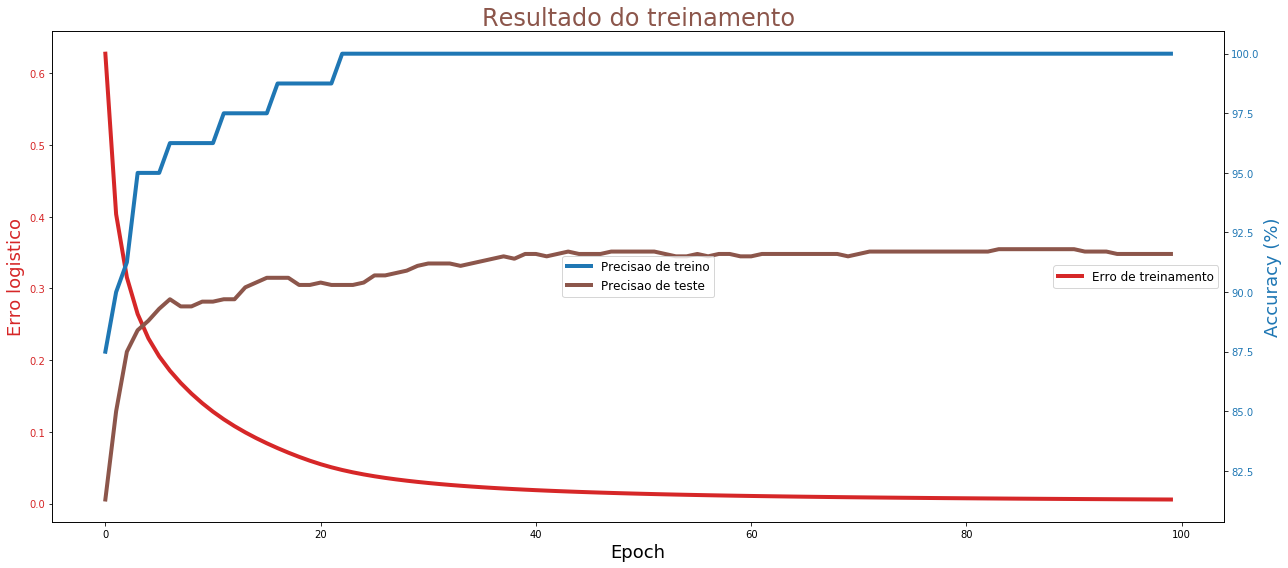

In [33]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

## 5.3 <span style='color:darkmagenta'>Discussão</span>
Pelos resultados acima, alguns eventos parecem ocorrer ao utilizarmos *Mini-Batch Gradient Descent*, em comparação com *Batch Gradient Descent*:
- O algoritmo converge mais rápido, e chega a alcançar 100% de precisão no conjunto de treinamento. Isso claramente se deve ao fato de que mais passos de otimização são dados por época.
- Já o erro empírico (precisão de teste) se "descola" mais do erro de treinamento, provavelmente devido à parte "randômica" envolvida.


#### <span style='color:darkmagenta'>Premissa</span>
**A partir deste ponto será reduzido o número de épocas para 50**, o que aparentemente não impacta na qualidade final.

### Teste 10/15: <span style='color:orangered'>Mini-batch / 50 unidades / Tx_aprend = 0.5</span>

In [34]:
# Teste 10: Configuracoes
n_hidden = 50         # numero de unidades na camada escondida
learning_rate = 0.5   # taxa de aprendizado
n_epochs = 50         # numero de epocas
n_batches = 50        # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [35]:
# Executa teste
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 0.8111 	 Accuracy: 83.75%
Epoch: 5 	 Logistic Loss: 0.2943 	 Accuracy: 91.25%
Epoch: 10 	 Logistic Loss: 0.2169 	 Accuracy: 93.75%
Epoch: 15 	 Logistic Loss: 0.1682 	 Accuracy: 95.00%
Epoch: 20 	 Logistic Loss: 0.1295 	 Accuracy: 96.25%
Epoch: 25 	 Logistic Loss: 0.0978 	 Accuracy: 97.50%
Epoch: 30 	 Logistic Loss: 0.0734 	 Accuracy: 97.50%
Epoch: 35 	 Logistic Loss: 0.0565 	 Accuracy: 98.75%
Epoch: 40 	 Logistic Loss: 0.0451 	 Accuracy: 100.00%
Epoch: 45 	 Logistic Loss: 0.0370 	 Accuracy: 100.00%
Epoch: 49 	 Logistic Loss: 0.0321 	 Accuracy: 100.00%


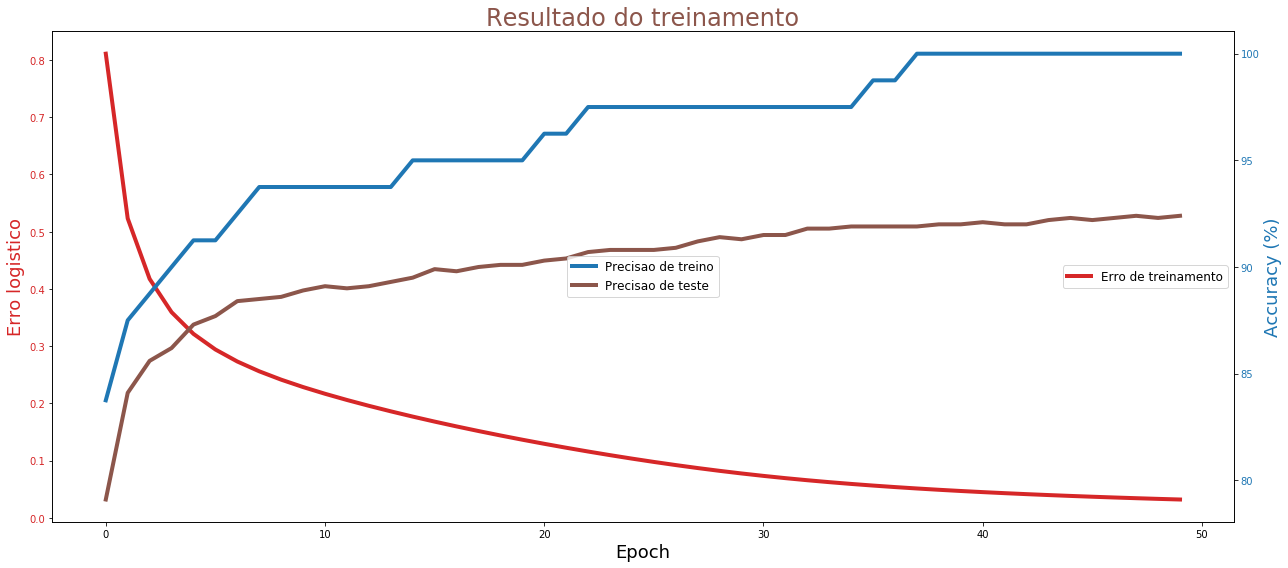

In [36]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 11/15: <span style='color:orangered'>Mini-batch / 50 unidades / Tx_aprend = 1</span>

In [37]:
# Teste 11: Configuracoes
n_hidden = 50         # numero de unidades na camada escondida
learning_rate = 1.0   # taxa de aprendizado
n_epochs = 50         # numero de epocas
n_batches = 50        # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [38]:
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 0.5287 	 Accuracy: 86.25%
Epoch: 5 	 Logistic Loss: 0.1767 	 Accuracy: 93.75%
Epoch: 10 	 Logistic Loss: 0.0920 	 Accuracy: 97.50%
Epoch: 15 	 Logistic Loss: 0.0545 	 Accuracy: 100.00%
Epoch: 20 	 Logistic Loss: 0.0359 	 Accuracy: 100.00%
Epoch: 25 	 Logistic Loss: 0.0251 	 Accuracy: 100.00%
Epoch: 30 	 Logistic Loss: 0.0187 	 Accuracy: 100.00%
Epoch: 35 	 Logistic Loss: 0.0148 	 Accuracy: 100.00%
Epoch: 40 	 Logistic Loss: 0.0121 	 Accuracy: 100.00%
Epoch: 45 	 Logistic Loss: 0.0103 	 Accuracy: 100.00%
Epoch: 49 	 Logistic Loss: 0.0091 	 Accuracy: 100.00%


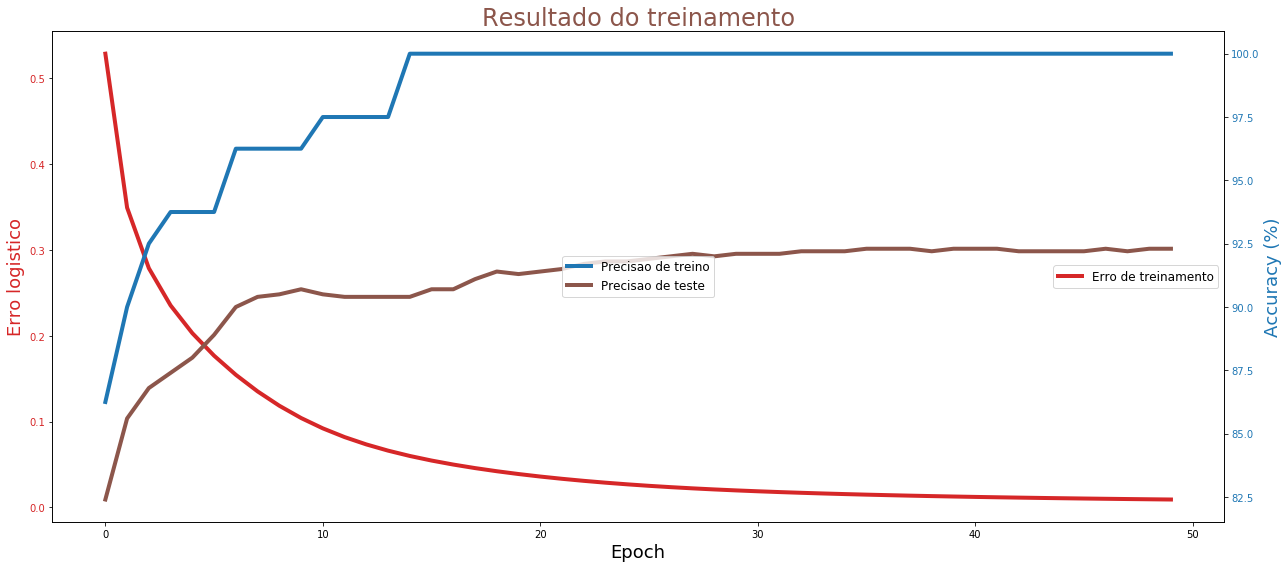

In [39]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 12/15: <span style='color:orangered'>Mini-batch / 100 unidades / Tx_aprend = 0.5</span>

In [40]:
# Teste 12: Configuracoes
n_hidden = 100        # numero de unidades na camada escondida
learning_rate = 0.5   # taxa de aprendizado
n_epochs = 50         # numero de epocas
n_batches = 50        # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [41]:
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 0.7529 	 Accuracy: 82.50%
Epoch: 5 	 Logistic Loss: 0.2803 	 Accuracy: 92.50%
Epoch: 10 	 Logistic Loss: 0.2048 	 Accuracy: 93.75%
Epoch: 15 	 Logistic Loss: 0.1557 	 Accuracy: 95.00%
Epoch: 20 	 Logistic Loss: 0.1158 	 Accuracy: 97.50%
Epoch: 25 	 Logistic Loss: 0.0842 	 Accuracy: 97.50%
Epoch: 30 	 Logistic Loss: 0.0618 	 Accuracy: 97.50%
Epoch: 35 	 Logistic Loss: 0.0468 	 Accuracy: 100.00%
Epoch: 40 	 Logistic Loss: 0.0365 	 Accuracy: 100.00%
Epoch: 45 	 Logistic Loss: 0.0293 	 Accuracy: 100.00%
Epoch: 49 	 Logistic Loss: 0.0249 	 Accuracy: 100.00%


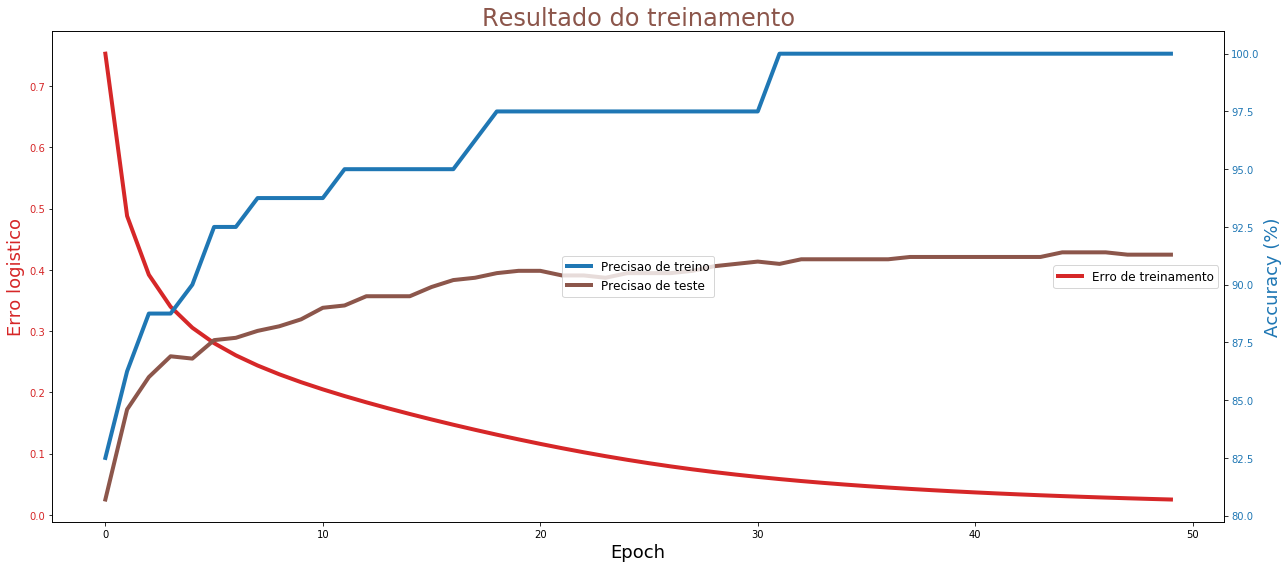

In [42]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 13/15: <span style='color:orangered'>Mini-batch / 100 unidades / Tx_aprend = 1</span>

In [43]:
# Teste 13: Configuracoes
n_hidden = 100        # numero de unidades na camada escondida
learning_rate = 1.0   # taxa de aprendizado
n_epochs = 50         # numero de epocas
n_batches = 50        # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [44]:
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 0.5178 	 Accuracy: 86.25%
Epoch: 5 	 Logistic Loss: 0.1884 	 Accuracy: 95.00%
Epoch: 10 	 Logistic Loss: 0.0986 	 Accuracy: 97.50%
Epoch: 15 	 Logistic Loss: 0.0514 	 Accuracy: 100.00%
Epoch: 20 	 Logistic Loss: 0.0322 	 Accuracy: 100.00%
Epoch: 25 	 Logistic Loss: 0.0221 	 Accuracy: 100.00%
Epoch: 30 	 Logistic Loss: 0.0161 	 Accuracy: 100.00%
Epoch: 35 	 Logistic Loss: 0.0124 	 Accuracy: 100.00%
Epoch: 40 	 Logistic Loss: 0.0099 	 Accuracy: 100.00%
Epoch: 45 	 Logistic Loss: 0.0082 	 Accuracy: 100.00%
Epoch: 49 	 Logistic Loss: 0.0072 	 Accuracy: 100.00%


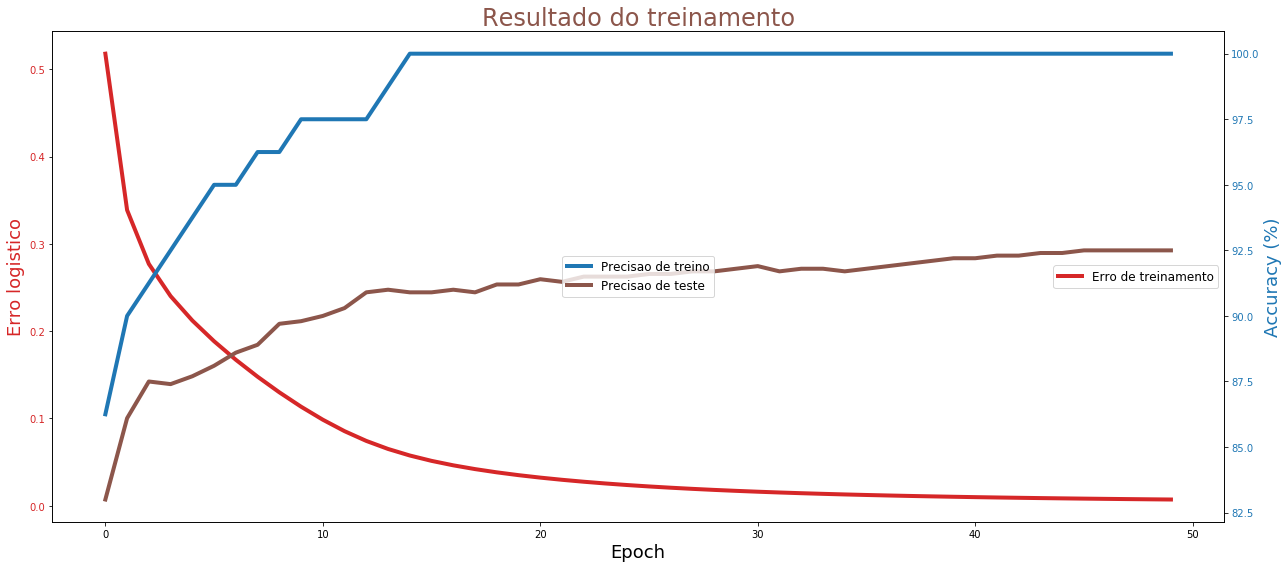

In [45]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

## 5.4 <span style='color:darkmagenta'>Discussão</span>
A utilização de *Mini-batch Gradient Descent* levou a resultados **sensivelmente melhores** em comparação com os obtidos para *Batch Gradient Descent*. A precisão de teste consistentemente ultrapassou 90%.

Novamente, **os ganhos em função do número de unidades foram praticamente insignificantes**.

Houve um **ganho marginal ao utilizar taxas de aprendizado iguais a 1**, em vez de 0.5. Aparentemente, vale a pena dar passos um pouco maiores no caso do *Mini-batch*.


#### <span style='color:darkmagenta'>Premissa</span>
**A partir deste ponto usaremos exclusivamente 50 unidades na camada escondida**, pois, pelos resultados anteriores, aumentar para 100 não leva a uma melhora significativa, e 50 é um bom compromisso para que a rede não fique pequena demais também.

### Teste 14/15: <span style='color:orangered'>Stochastic / 50 unidades / Tx_aprend = 0.5</span>
No último grupo de testes, utilizaremos *Stochastic Gradient Descent*.

#### <span style='color:darkmagenta'>Premissa</span>
**Devido ao alto número de avaliações por época (4000), a partir de agora iremos iterar apenas para 20 épocas**.

In [46]:
# Teste 14: Configuracoes
n_hidden = 50         # numero de unidades na camada escondida
learning_rate = 0.5   # taxa de aprendizado
n_epochs = 20         # numero de epocas
n_batches = m         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [47]:
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 2.2632 	 Accuracy: 15.55%
Epoch: 5 	 Logistic Loss: 2.0234 	 Accuracy: 59.75%
Epoch: 10 	 Logistic Loss: 1.8088 	 Accuracy: 68.52%
Epoch: 15 	 Logistic Loss: 1.6121 	 Accuracy: 71.78%
Epoch: 19 	 Logistic Loss: 1.4712 	 Accuracy: 73.90%


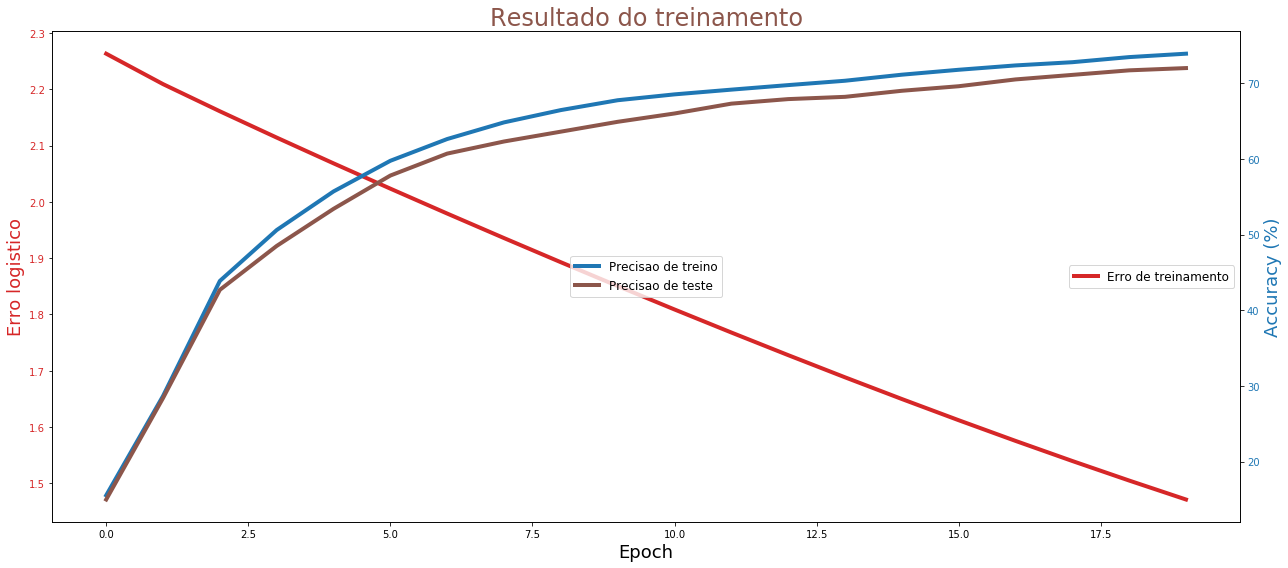

In [48]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

### Teste 15/15: <span style='color:orangered'>Stochastic / 50 unidades / Tx_aprend = 1.0</span>

In [49]:
# Teste 15: Configuracoes
n_hidden = 50         # numero de unidades na camada escondida
learning_rate = 1.0   # taxa de aprendizado
n_epochs = 20         # numero de epocas
n_batches = m         # numero de batches
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # algoritmo de otimizacao: Gradient Descent

In [50]:
loss_vec, accuracy_vec, test_vec = executa_rede(data=data, 
                                                dim=(784,n_hidden,10), 
                                                optimizer=optimizer, 
                                                n_epochs=n_epochs,
                                                n_batches=n_batches) 

Epoch: 0 	 Logistic Loss: 2.2613 	 Accuracy: 13.65%
Epoch: 5 	 Logistic Loss: 1.8056 	 Accuracy: 65.50%
Epoch: 10 	 Logistic Loss: 1.4463 	 Accuracy: 75.38%
Epoch: 15 	 Logistic Loss: 1.1741 	 Accuracy: 78.22%
Epoch: 19 	 Logistic Loss: 1.0191 	 Accuracy: 80.43%


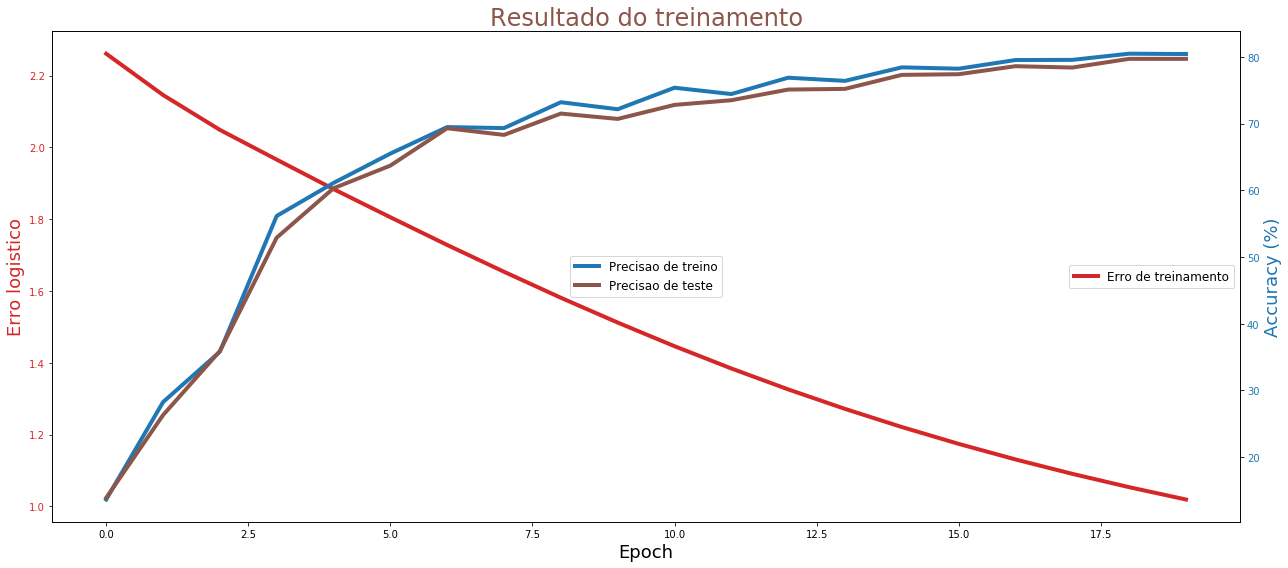

In [51]:
plota_resultados(accuracy_vec=accuracy_vec, loss_vec=loss_vec, test_vec=test_vec)

## 5.5 <span style='color:darkmagenta'>Discussão</span>
Os resultados com o uso de *Stochastic Gradient Descent* foram os piores dentre todos analisados. Talvez com mais tempo de execução, ou um ajuste melhor dos parâmetros seja possível alcançar melhores resultados, pois os gráficos não indicam estagnação, mas parece improvável que para uma rede tão limitada seja aceitável uma execução demorada.

# Conclusão
Dentre as configurações estudadas, aquela que apresentou **maior impacto no resultado final** foi a escolha do **algoritmo de cálculo do gradiente**. Enquanto *Batch Gradient Descent* obteve bons resultados de teste, porém sub-ótimos e mais demorados, e *Stochastic Gradient Descent* foi o pior tanto em tempo quanto em precisão, *Mini-batch Gradient Descent* conseguiu as melhores taxas de reconhecimento (acima de 90%).

Em relação às outras configurações, a taxa de aprendizado de 10 pareceu muito alta, levando a divergências, enquanto entre as duas outras, dado que estávamos utilizando *Gradient Descent* como otimizador (o qual não é tão bom), a taxa de 1 aparenta levar a resultados competitivos, porém mais rápido. Já o número de unidades na camada escondida, surpreendentemente, não teve um impacto considerável no resultado final. Especulamos, portanto, que o tamanho da rede (número de camadas) é mais relevante para melhorar a qualidade dos resultados do que o número de unidades nesta única camada.

Para melhorar este trabalho, as duas principais iniciativas promissoras seriam:
1. Obter um dataset maior e utilizar otimizadores mais eficientes (por exemplo, o Adam)
- Aumentar o tamanho da rede. Acredito que uma camada a mais já seria suficiente para elevar o acerto de teste de forma significativa.

# Referências

1. *Hands-on Machine Learning with Scikit-Learn & Tensorflow* - Aurélien Géron, 2017
- *Deep Learning Specialization* - Andrew Ng, Coursera, 2018